# Automatic Summarization

We combine methods studied in previous research, and evaluate their improvements to a event summarization problem on Twitter. Namely, we combine state-of-the-art selection algorithms including our own likely event model, predictive filtering, 

## Step 1: Selection
Narrow the raw corpus down to a selection pool of reasonable size for summary generation. The approaches compared are:
1. Random
2. Verified User
3. Engagements
4. TF-IDF Rank
5. Clustering
6. Noun Phrase (NP+V+NP)
7. Likely Event Model
    - classification algorithm to predict news in tweets

#### Issues present
- uninformative documents
    - do not contain news or event updates
- low quality documents
    - questions
    - advertisement
    - personal opinion
    - explicit language
- not representative distribution
    - documents concentrated at one time

### Evaluate
1. manual event annotation
    - measure precision, recall, f-1 of actual events

## Step 2: Filtering
Perform filtering of event corpus using predictive modeling, and rerun selection methods. Evaluate the summary pools again. We predicte the following for exclusion.
    - questions
    - advertisement
    - personal opinion
    - explicit language

### Evaluate
1. manual event annotation
    - measure precision, recall, f-1 of actual events

## Step 3: Event Detection
Apply event detection algorithm to identify time intervals of summary importance.

### Evaluate
1. manual event annotation
    - measure precision, recall, f-1 of actual events

## Step 4: Novelty Selection
Perform state of the art temporal-novelty selection on each selection pool

1. TF-IDF Centroid Distance
2. K-Terms

#### import tools

In [2]:
import pandas as pd
import numpy as np

import nltk
from nltk import TweetTokenizer
import string
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

#### import data

In [3]:
df = pd.read_table('data/final/event_indianaprimary_data.txt', sep='\t', encoding='utf-8', header=0, low_memory=False)
df.shape

(54162, 34)

In [4]:
df.loc[:,('created_at')] = pd.to_datetime(df['created_at'])

In [5]:
#remove links
df['text_clean'] = df['text'].apply(lambda text: ' '.join([(w[:w.find('http')] if 'http' in w else w) for w in text.split()]))

#remove hashtag symbol
df['text_clean'] = df['text_clean'].apply(lambda text: text.replace('#', ''))

#remove mention symbol
df['text_clean'] = df['text_clean'].apply(lambda text: text.replace('@', ''))

#initiate, apply tokenization
tknzr = TweetTokenizer()
df['text_clean'] = df['text_clean'].apply(lambda s: ' '.join([w.lower() for w in tknzr.tokenize(str(s))]))

#### define k docs
- summarize using 10 doc selection

In [6]:
k_docs = 20

#### random sample of 1k
- for testing algorithms
- filter retweets, replies from data

In [7]:
df_smpl = df[(df['is_retweet'] == False) & (df['is_reply'] == False)].sample(1000, random_state=2016)
#sort values for selection
df_smpl.sort_values(by='created_at', ascending=True, inplace=True)
#reset index for merging calcs
df_smpl.reset_index(drop=True, inplace=True)

#### define timeseries bounds

In [8]:
timeseries = pd.date_range(df['created_at'].min().strftime('%Y-%m-%d %H'), df['created_at'].max().strftime('%Y-%m-%d %H'), freq='H')

# visualize selections over time

In [43]:
d_total = df.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_total = d_total.reindex(timeseries, fill_value=0)
d_total['percent'] = d_total['count'].apply(lambda c: round(c/d_total['count'].sum() * 100, 2))
d_total['corpus'] = 'total'

In [44]:
d_smpl = df_smpl.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_smpl = d_smpl.reindex(timeseries, fill_value=0)
d_smpl['percent'] = d_smpl['count'].apply(lambda c: round(c/d_smpl['count'].sum() * 100, 2))
d_smpl['corpus'] = 'sample 1k'

In [45]:
d = pd.concat([d_total, d_smpl])

corpus
sample 1k    Axes(0.125,0.125;0.775x0.775)
total        Axes(0.125,0.125;0.775x0.775)
Name: percent, dtype: object

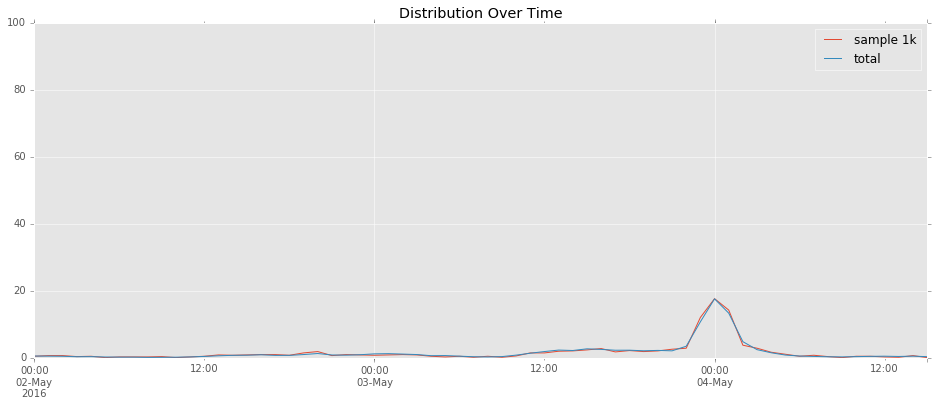

In [46]:
d.groupby('corpus')['percent'].plot(figsize=(16,6),
                                    ylim=(0,100),
                                    legend=True,
                                    title='Distribution Over Time')

In [47]:
d_rndm = df_rndm.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_rndm = d_rndm.reindex(timeseries, fill_value=0)
d_rndm['percent'] = d_rndm['count'].apply(lambda c: round(c/d_rndm['count'].sum() * 100, 2))
d_rndm['corpus'] = 'k-doc random'

In [48]:
d_veri = df_veri.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_veri = d_veri.reindex(timeseries, fill_value=0)
d_veri['percent'] = d_veri['count'].apply(lambda c: round(c/d_veri['count'].sum() * 100, 2))
d_veri['corpus'] = 'k-doc verified'

In [49]:
d_eng = df_eng.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_eng = d_eng.reindex(timeseries, fill_value=0)
d_eng['percent'] = d_eng['count'].apply(lambda c: round(c/d_eng['count'].sum() * 100, 2))
d_eng['corpus'] = 'k-doc engagements'

corpus
k-doc engagements    Axes(0.125,0.125;0.775x0.775)
k-doc random         Axes(0.125,0.125;0.775x0.775)
k-doc verified       Axes(0.125,0.125;0.775x0.775)
Name: percent, dtype: object

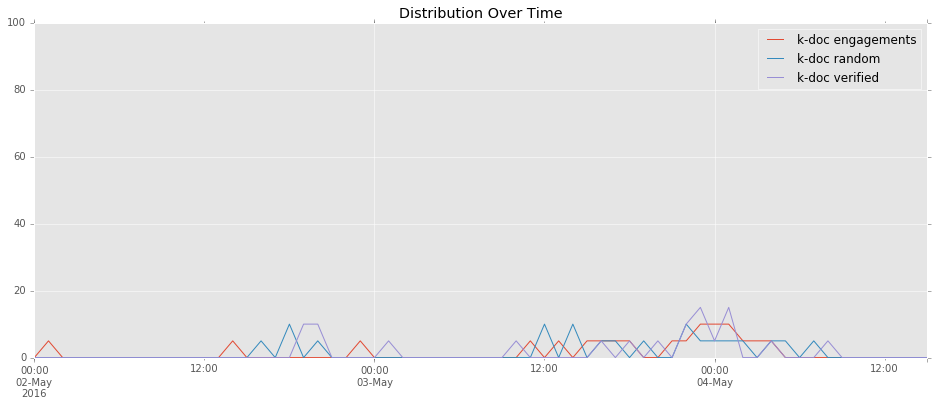

In [50]:
d = pd.concat([d_rndm, d_veri, d_eng])
d.groupby('corpus')['percent'].plot(figsize=(16,6),
                                    ylim=(0,100),
                                    legend=True,
                                    title='Distribution Over Time')

In [51]:
d_tfidf = df_tfidf.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_tfidf = d_tfidf.reindex(timeseries, fill_value=0)
d_tfidf['percent'] = d_tfidf['count'].apply(lambda c: round(c/d_tfidf['count'].sum() * 100, 2))
d_tfidf['corpus'] = 'k-doc tfidf'

In [52]:
d_tfidf_stpd = df_tfidf_stpd.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_tfidf_stpd = d_tfidf_stpd.reindex(timeseries, fill_value=0)
d_tfidf_stpd['percent'] = d_tfidf_stpd['count'].apply(lambda c: round(c/d_tfidf_stpd['count'].sum() * 100, 2))
d_tfidf_stpd['corpus'] = 'k-doc tfidf stopped'

In [53]:
d_tfidf_clnd = df_tfidf_clnd.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_tfidf_clnd = d_tfidf_clnd.reindex(timeseries, fill_value=0)
d_tfidf_clnd['percent'] = d_tfidf_clnd['count'].apply(lambda c: round(c/d_tfidf_clnd['count'].sum() * 100, 2))
d_tfidf_clnd['corpus'] = 'k-doc tfidf cleaned'

In [54]:
d_tfidf_adj = df_tfidf_adj.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_tfidf_adj = d_tfidf_adj.reindex(timeseries, fill_value=0)
d_tfidf_adj['percent'] = d_tfidf_adj['count'].apply(lambda c: round(c/d_tfidf_adj['count'].sum() * 100, 2))
d_tfidf_adj['corpus'] = 'k-doc tfidf adjusted'

corpus
k-doc tfidf             Axes(0.125,0.125;0.775x0.775)
k-doc tfidf adjusted    Axes(0.125,0.125;0.775x0.775)
k-doc tfidf cleaned     Axes(0.125,0.125;0.775x0.775)
k-doc tfidf stopped     Axes(0.125,0.125;0.775x0.775)
Name: percent, dtype: object

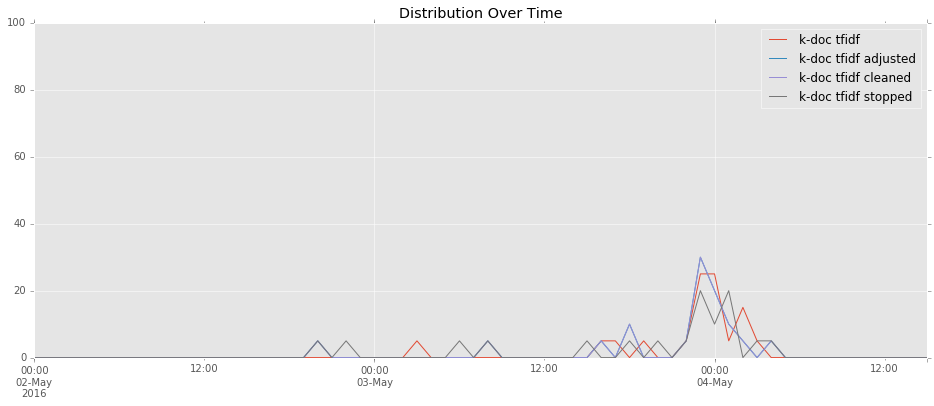

In [55]:
d = pd.concat([d_tfidf, d_tfidf_stpd, d_tfidf_clnd, d_tfidf_adj])
d.groupby('corpus')['percent'].plot(figsize=(16,6),
                                    ylim=(0,100),
                                    legend=True,
                                    title='Distribution Over Time')

In [56]:
d_clust_first = df_clust_first.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_clust_first = d_clust_first.reindex(timeseries, fill_value=0)
d_clust_first['percent'] = d_clust_first['count'].apply(lambda c: round(c/d_clust_first['count'].sum() * 100, 2))
d_clust_first['corpus'] = 'k-doc cluster first'

In [57]:
d_clust_last = df_clust_last.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_clust_last = d_clust_last.reindex(timeseries, fill_value=0)
d_clust_last['percent'] = d_clust_last['count'].apply(lambda c: round(c/d_clust_last['count'].sum() * 100, 2))
d_clust_last['corpus'] = 'k-doc cluster last'

In [58]:
d_clust_wght = df_clust_wght.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_clust_wght = d_clust_wght.reindex(timeseries, fill_value=0)
d_clust_wght['percent'] = d_clust_wght['count'].apply(lambda c: round(c/d_clust_wght['count'].sum() * 100, 2))
d_clust_wght['corpus'] = 'k-doc cluster weighted'

corpus
k-doc cluster first       Axes(0.125,0.125;0.775x0.775)
k-doc cluster last        Axes(0.125,0.125;0.775x0.775)
k-doc cluster weighted    Axes(0.125,0.125;0.775x0.775)
Name: percent, dtype: object

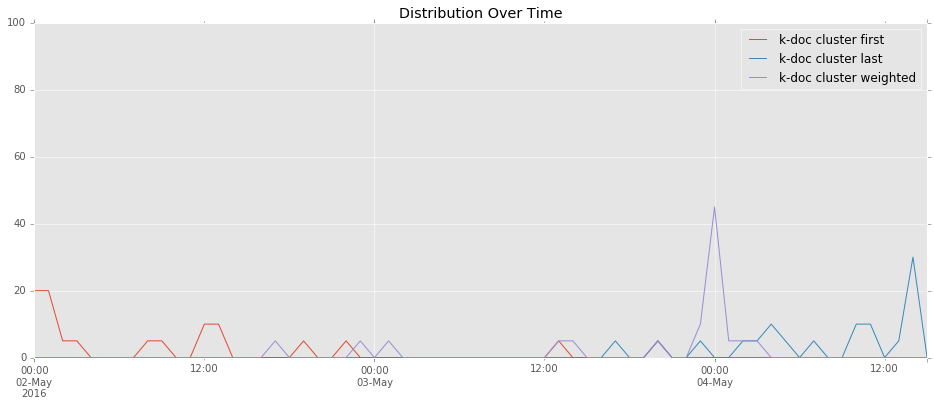

In [59]:
d = pd.concat([d_clust_first, d_clust_last, d_clust_wght])
d.groupby('corpus')['percent'].plot(figsize=(16,6),
                                    ylim=(0,100),
                                    legend=True,
                                    title='Distribution Over Time')

In [60]:
d_NPV_rndm = df_NPV_rndm.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_NPV_rndm = d_NPV_rndm.reindex(timeseries, fill_value=0)
d_NPV_rndm['percent'] = d_NPV_rndm['count'].apply(lambda c: round(c/d_NPV_rndm['count'].sum() * 100, 2))
d_NPV_rndm['corpus'] = 'k-doc noun phrase + verb'

In [61]:
d_NPVNP_rndm = df_NPVNP_rndm.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_NPVNP_rndm = d_NPVNP_rndm.reindex(timeseries, fill_value=0)
d_NPVNP_rndm['percent'] = d_NPVNP_rndm['count'].apply(lambda c: round(c/d_NPVNP_rndm['count'].sum() * 100, 2))
d_NPVNP_rndm['corpus'] = 'k-doc noun phrase + verb + noun phrase'

corpus
k-doc noun phrase + verb                  Axes(0.125,0.125;0.775x0.775)
k-doc noun phrase + verb + noun phrase    Axes(0.125,0.125;0.775x0.775)
Name: percent, dtype: object

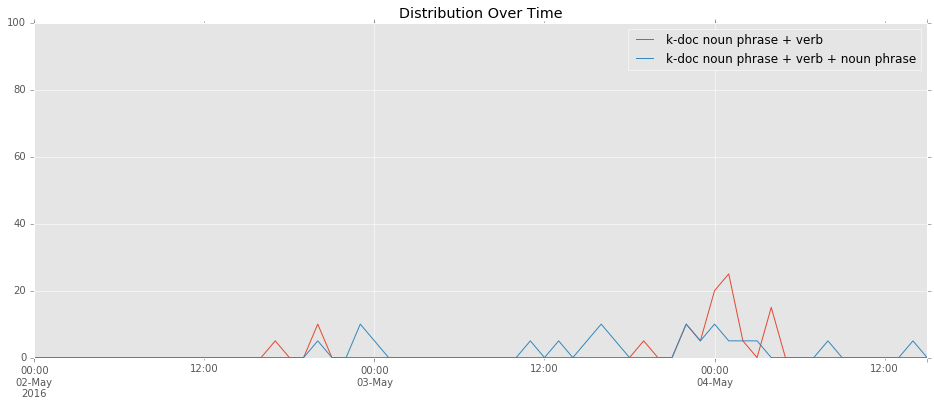

In [62]:
d = pd.concat([d_NPV_rndm, d_NPVNP_rndm])
d.groupby('corpus')['percent'].plot(figsize=(16,6),
                                    ylim=(0,100),
                                    legend=True,
                                    title='Distribution Over Time')

# Step 1
## 1. Random Selection
### method:
Select k random documents from corpus

In [9]:
df_rndm = df_smpl.sample(k_docs, random_state=2016)
summ = df_rndm.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 16:41:03	We The People Choose #Trump #VoteTrump #Trump2016 #CruzCrew SINKS #INPrimary #IndianaPrimary #CAPrimary #AlwaysTrump https://t.co/6dUU3xpmLm
2016-05-02 18:32:54	#CaliforniaPrimary #CaPrimary #IndianaPrimary #InPrimary why is #TedCruz such a liar. trump supports 2nd amed https://t.co/6hKqrVyb0S
2016-05-02 18:40:52	MT @Karee_news: #IndianaPrimary #Conservatives across this land are counting you to #ChooseCruz. https://t.co/wuAb24QMEy #CruzCrew #PJNET
2016-05-02 20:27:30	#StephanieCegielski On #RealDonaldTrump The hard truth is: #Trump only cares about #Trump. #IndianaPrimary #MakeAmericaHateAgain
2016-05-03 12:48:01	She can't beat trump. #IndianaPrimary #FeelTheBern  https://t.co/T39xJAHvrw
2016-05-03 12:49:29	Good Morning #Indiana  Today is the Day! SHOW YOUR AMERICAN PRIDE and VOTE FOR TRUMP! #IndianaPrimary  #Trump2016 https://t.co/ZXiOLaVVLe
2016-05-03 14:39:24	What Hoosiers are Googling before the Indiana primary | Indiana Primary https://t.co/ROJfybXaAt #indiana

## 2. Verified User Selection
### method:
Select k random docs from verified users

In [10]:
df_veri = df_smpl[df_smpl['user_verified'] == True].sample(min(k_docs, df_smpl[df_smpl['user_verified'] == True].shape[0]), random_state=2016)
summ = df_veri.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 19:35:18	Live now on @facebook. Ask me a question &gt; https://t.co/wdKdBxA0Be #IndianaPrimary
2016-05-02 19:48:01	Indiana's strict #voterID law was upheld by #scotus in 2008. What to know about #voterID: https://t.co/PfjpZ2Hg59 #IndianaPrimary
2016-05-02 20:04:00	I dont get how someone can be that nasty. At least @tedcruz had the 🏐⚽️🏀 to face/visit the crowd. #IndianaPrimary
2016-05-02 20:32:41	WATCH NOW: Trump speaks at a rally in Carmel, Ind. ahead of #IndianaPrimary https://t.co/2fyNEZG6NI https://t.co/nZZLCgppJ0
2016-05-03 01:38:51	On the brink of the nomination, Donald tones down the Trump. @GriffinLeeds before the #IndianaPrimary https://t.co/ZQ9wImMpqU via @TheTab
2016-05-03 10:06:42	We've got team coverage of the #IndianaPrimary on @FOX59 all morning! @Kyle_Inskeep @JillianDeam https://t.co/SSrAZ6LSud
2016-05-03 16:45:24	Trump Says Cruz's Dad Shouldn't Be Allowed to Talk About Religion #IndianaPrimary  https://t.co/Hlw8HPTnQ4
2016-05-03 18:28:49	"I'm the rose betwee

## 3. Engagements Selection
### method:
Select k docs with highest engagements

In [11]:
df_smpl['engagements'] = df_smpl['favorite_count'] + df_smpl['retweet_count']

In [12]:
df_eng = df_smpl.sort_values(by='engagements', ascending=False).head(k_docs)
summ = df_eng.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 01:43:17	.@realDonaldTrump whoops, look what I found,MSM! #IndianaPrimary #Trump2016 #TrumpTrain #Indiana #Hoosiers4Trump https://t.co/TxGaI6jCQZ
2016-05-02 14:40:04	Breaking News: @realDonaldTrump has won NOTHING! He hasn't won the GOP nomination &amp; won't. Stop listening to propaganda! :) #IndianaPrimary
2016-05-02 23:32:30	In South Bend, where @tedcruz needs strong vote, @realDonaldTrump draws SRO to Century Center. #IndianaPrimary https://t.co/B98cTeqbpd
2016-05-03 11:33:48	#IndianaPrimary #ElectionDay  wake up America! #HillNo #NeverHillary  https://t.co/FljCfaB7ZH
2016-05-03 13:59:54	🔥KICK OUT THAT VIOLENT PROTESTOR🔥 Omg @Morning_Joe slaying @tedcruz this morning! #IndianaPrimary 🏀 #TrumpTrain 🚂💨 https://t.co/9rCtwTi4Sa
2016-05-03 15:39:37	If you’re #StillSanders, stop checking “who’s with her” and get to work!: https://t.co/rNRrRZkIxi - via:@TheBernReport #IndianaPrimary
2016-05-03 16:16:38	#WomenForTrump: we don't fit your broadbrush attacks of demeaning generaliza

## 4. TF-IDF Rank
### method:
Computes weights for each document using term frequencies and selects k best documents. The term frquency inverse document frequency equation computes a term importance which is higher if the term is frequent in one document but rare in the total corpus.

In [13]:
t0 = time()
#initialize sklearn vectorizer
tfidf_vectorizer = TfidfVectorizer()
print("done in %fs" % (time() - t0))

#create matrix of tfidf counts
Xtfidf = tfidf_vectorizer.fit_transform(df_smpl['text'])
print("n_samples: %d, n_features: %d" % Xtfidf.shape)

done in 0.000000s
n_samples: 1000, n_features: 3443


In [14]:
#get sum tfidf for each doc
Xtfidf_sums = Xtfidf.sum(axis=1)
df_tfidf_sums = pd.DataFrame(Xtfidf_sums, columns=['tfidf_sum'])

df_smpl = pd.merge(df_smpl, df_tfidf_sums, left_index=True, right_index=True)

In [15]:
df_tfidf = df_smpl.sort_values(by='tfidf_sum', ascending=False).head(k_docs)
summ = df_tfidf.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-03 03:14:39	Trump will win the #IndianaPrimary and get more then 50% of the vote bet on it! Time to start focusing on the real enemy #NeverHillary !
2016-05-03 16:40:53	If @tedcruz loses #IndianaPrimary today, I hope he will go next logical step: endorse or run as 3rd party candidate. https://t.co/7XYUDNffVB
2016-05-03 17:52:38	Trump is being sued for Fraud &amp; Sexual Assault but please Twitter, tell me more about how Cruz's dad killed JFK #IndianaPrimary #ChooseCruz
2016-05-03 19:25:50	Trump is mad that no one brings up his friends story in the national enquirer, so he dumb enough to bring it up himself #IndianaPrimary
2016-05-03 22:36:52	Indiana folks should really be voting on what makes them laugh harder, Trump's small hands or Cruz being the zodiac killer. #IndianaPrimary
2016-05-03 23:30:20	We are taking your calls now live on @NewsmaxTV. This is your time to speak out and be heard by #America. Call 877-NEWSMAX. #IndianaPrimary
2016-05-03 23:43:56	The Democratic race is

#### tfidf stopped

In [16]:
t0 = time()
#initialize sklearn vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
print("done in %fs" % (time() - t0))

#create matrix of tfidf counts
Xtfidf = tfidf_vectorizer.fit_transform(df_smpl['text'])
print("n_samples: %d, n_features: %d" % Xtfidf.shape)

done in 0.000000s
n_samples: 1000, n_features: 3235


In [17]:
#get sum tfidf for each doc
Xtfidf_sums = Xtfidf.sum(axis=1)
df_tfidf_sums = pd.DataFrame(Xtfidf_sums, columns=['tfidf_stpd_sum'])

df_smpl = pd.merge(df_smpl, df_tfidf_sums, left_index=True, right_index=True)

In [18]:
df_tfidf_stpd = df_smpl.sort_values(by='tfidf_stpd_sum', ascending=False).head(k_docs)
summ = df_tfidf_stpd.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 20:48:55	@deneenborelli #IndianaPrimary VOTE for #Trump fight BS MSM picking on 1  INDIANA child for yelling 2 words IGNORE 100's of worse Protests.
2016-05-02 22:09:38	SR 821 Jeff Sessions: Obama to Sneak TPP Thru! #IndianaPrimary #INPrimary #TrumpTrain #Trump2016 #NeverCruz WATCH--&gt;https://t.co/Be0xPQmhMO
2016-05-03 06:20:15	@tedcruz #IndianaPrimary  Th momnt of human concptn captrd in thse pictrs. Bst reason to vte for #CruzCarly2016 https://t.co/8E3w9gD3Ud
2016-05-03 08:04:30	.@HillaryClinton says "I didn't mean it that way" reference to costing coal miners jobs. Just utter bullshit! #IndianaPrimary #FeelTheBern
2016-05-03 15:03:47	Political Speak: Small Business GOP= multinational corporate polluters DEM= companies &lt;50 employees #IndianaPrimary https://t.co/PYNkWKn9BY
2016-05-03 18:15:19	@tedcruz recent outburst &amp; desperate reach for attention is difficult to watch...kinda like watching a house go up in flames #IndianaPrimary
2016-05-03 20:04:39	#IndianaPrimar

#### tfidf cleaned

In [19]:
t0 = time()
#initialize sklearn vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
print("done in %fs" % (time() - t0))

#create matrix of tfidf counts
Xtfidf = tfidf_vectorizer.fit_transform(df_smpl['text_clean'])
print("n_samples: %d, n_features: %d" % Xtfidf.shape)

done in 0.000000s
n_samples: 1000, n_features: 2705


In [20]:
#get sum tfidf for each doc
Xtfidf_sums = Xtfidf.sum(axis=1)
df_tfidf_sums = pd.DataFrame(Xtfidf_sums, columns=['tfidf_clnd_sum'])

df_smpl = pd.merge(df_smpl, df_tfidf_sums, left_index=True, right_index=True)

In [21]:
df_tfidf_clnd = df_smpl.sort_values(by='tfidf_clnd_sum', ascending=False).head(k_docs)
summ = df_tfidf_clnd.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 20:48:55	@deneenborelli #IndianaPrimary VOTE for #Trump fight BS MSM picking on 1  INDIANA child for yelling 2 words IGNORE 100's of worse Protests.
2016-05-03 08:04:30	.@HillaryClinton says "I didn't mean it that way" reference to costing coal miners jobs. Just utter bullshit! #IndianaPrimary #FeelTheBern
2016-05-03 16:45:40	#IndianaPrimary this is your chance to make history! #Vote for @HillaryClinton - 1st major party woman nominee in 227 yrs! #Hillary2016
2016-05-03 18:15:19	@tedcruz recent outburst &amp; desperate reach for attention is difficult to watch...kinda like watching a house go up in flames #IndianaPrimary
2016-05-03 18:33:54	What goes thru the DNC's head? "Hey, we need the Independents to win in Nov! FUCK 'EM! Let em vote for #Trump." #TYT #IndianaPrimary #Bernie
2016-05-03 22:49:35	#IndianaPrimary @foxnews exit polls: 53% of Hoosiers say they feel betrayed by Republican politicians; 42% say Cruz ran most unfair campaign
2016-05-03 23:29:08	Hillary Clinton ca

#### tfidf adjusted

In [22]:
t0 = time()
#initialize sklearn vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, stop_words='english')
print("done in %fs" % (time() - t0))

#create matrix of tfidf counts
Xtfidf = tfidf_vectorizer.fit_transform(df_smpl['text_clean'])
print("n_samples: %d, n_features: %d" % Xtfidf.shape)

done in 0.000000s
n_samples: 1000, n_features: 2704


In [23]:
#get sum tfidf for each doc
Xtfidf_sums = Xtfidf.sum(axis=1)
df_tfidf_sums = pd.DataFrame(Xtfidf_sums, columns=['tfidf_adj_sum'])

df_smpl = pd.merge(df_smpl, df_tfidf_sums, left_index=True, right_index=True)

In [24]:
df_tfidf_adj = df_smpl.sort_values(by='tfidf_adj_sum', ascending=False).head(k_docs)
summ = df_tfidf_adj.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 20:48:55	@deneenborelli #IndianaPrimary VOTE for #Trump fight BS MSM picking on 1  INDIANA child for yelling 2 words IGNORE 100's of worse Protests.
2016-05-03 08:04:30	.@HillaryClinton says "I didn't mean it that way" reference to costing coal miners jobs. Just utter bullshit! #IndianaPrimary #FeelTheBern
2016-05-03 16:45:40	#IndianaPrimary this is your chance to make history! #Vote for @HillaryClinton - 1st major party woman nominee in 227 yrs! #Hillary2016
2016-05-03 18:15:19	@tedcruz recent outburst &amp; desperate reach for attention is difficult to watch...kinda like watching a house go up in flames #IndianaPrimary
2016-05-03 18:33:54	What goes thru the DNC's head? "Hey, we need the Independents to win in Nov! FUCK 'EM! Let em vote for #Trump." #TYT #IndianaPrimary #Bernie
2016-05-03 22:49:35	#IndianaPrimary @foxnews exit polls: 53% of Hoosiers say they feel betrayed by Republican politicians; 42% say Cruz ran most unfair campaign
2016-05-03 23:29:08	Hillary Clinton ca

## 5. Cluster Selection
### method:
Cluster documents, select k docs / k clusters from each cluster, for an evenly distributed information pool.

In [25]:
t0 = time()
#initialize sklearn vectorizer
tfidf_vectorizer = TfidfVectorizer()
print("done in %fs" % (time() - t0))

#create matrix of tfidf counts
Xtfidf = tfidf_vectorizer.fit_transform(df_smpl['text_clean'])
print("n_samples: %d, n_features: %d" % Xtfidf.shape)

done in 0.000000s
n_samples: 1000, n_features: 2912


In [26]:
km = KMeans(n_clusters=k_docs, random_state=2016)

In [27]:
t0 = time()
km.fit(Xtfidf)
print("done in %fs" % (time() - t0))

done in 1.118277s


In [28]:
dfclust = pd.DataFrame(km.labels_, columns=['cluster'])

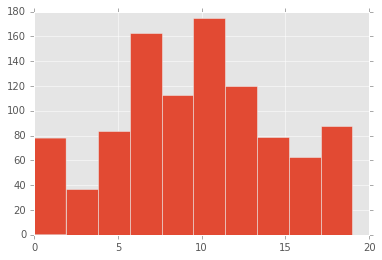

In [29]:
dfclust['cluster'].hist()

In [30]:
df_smpl = pd.merge(df_smpl, dfclust, left_index=True, right_index=True)

#### cluster first

In [31]:
df_clust_first = df_smpl.groupby('cluster').first()
summ = df_clust_first.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 00:21:31	#IndianaPrimary..why would anyone pay $353K to dine with Hillary?..wealthy people view this 'donation' as an investment and demand a return.
2016-05-02 00:25:34	Limbaugh: Ted Cruz Is ‘Inarguably Thoroughbred Conservative’ [VIDEO] https://t.co/0OVrmj16zm  #RedNationRising #Indianaprimary #CruzCrew
2016-05-02 00:30:43	🚨#Bernie WINS when voter turnout is #YUGE Find Polls ☑https://t.co/8GMbIaoSqf #VoteBernie #IndianaPrimary #INPrimary https://t.co/Ez5TdlDC32
2016-05-02 00:33:59	We already know when #Trump wins huge in #IndianaPrimary, @tedcruz will posit the #CaliforniaPrimary hinges on everything. Rinse and repeat.
2016-05-02 01:11:48	It all comes to the Crossroads of America! #IndianaPrimary #INPrimary #INPrimary2016 #Indianoplace
2016-05-02 01:38:09	#indianaprimary Clint Eastwood  ENDORSES Donald J. Trump for President Of The United States.  SHUT UP https://t.co/vqQBCDRVJy
2016-05-02 01:43:17	.@realDonaldTrump whoops, look what I found,MSM! #IndianaPrimary #Trump2016

#### cluster last

In [32]:
df_clust_last = df_smpl.groupby('cluster').last()
summ = df_clust_last.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-03 17:23:54	MT @Karee_news: #IndianaPrimary #Conservatives across this land are counting you to #ChooseCruz. https://t.co/V4It8w9VEw #CruzCrew #PJNET
2016-05-03 20:11:42	Donald Trump #DonaldTrump #INPrimary #Indiana #Nebraska #IndianaPrimary #Oregon #Washington #WVA #SD #OR #WA https://t.co/ZK5TpyZvWD
2016-05-03 23:34:15	Congratulations to Representative @ToddYoungIN for winning his #Indiana United States Senate Primary #INprimary  #INpolitics #IndianaPrimary
2016-05-04 02:58:17	@BernieSanders wins #IndianaPrimary but will @CNNPolitics let him speak before 11pm? No!! @CNN you suck!
2016-05-04 03:17:31	What the HELL did you think Fiorina was gonna do for you, Cruz? #IndianaPrimary
2016-05-04 04:21:47	Can we also acknowledge that the religious right do not have power to even get a win within Republican Party? #PaperTiger #IndianaPrimary -…
2016-05-04 04:45:58	Don't fret, America. There's still time to accept @HillaryClinton as your personal savior. #IndianaPrimary
2016-05-04 05:4

#### cluster weight random

In [33]:
dfclust_weights = pd.DataFrame(dfclust['cluster'].value_counts(normalize=True)).reset_index()
dfclust_weights.columns = [['cluster', 'cluster_weight']]

In [34]:
df_smpl = pd.merge(df_smpl, dfclust_weights, how='left', on='cluster')

In [35]:
df_clust_wght = df_smpl.sample(k_docs, weights='cluster_weight', random_state=2016)
summ = df_clust_wght.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + ' ' + str(doc['cluster']) + '\t' + doc['text'])

2016-05-02 17:22:52 13	Bill Clinton meets with Hillary Clinton supporters in Indianapolis  #IndianaPrimary  #INPrimary  #ImWithHer   https://t.co/BAt0XlKOxP
2016-05-02 23:21:53 16	Trump is Insane, Trump is Power Mad, Trump Is EVIL! #TrumpIsEvil #NeverTrump #IndianaPrimary #INPrimary #GOP https://t.co/NdfvDTdZ6k
2016-05-03 01:05:44 4	#kellyfile #IndianaPrimary #Hoosiers #HoosiersForTrump THANK YOU HOOSIERS! GET OUT AND VOTE! KEEP PUSHING AMERICA! https://t.co/56WLipdDkt
2016-05-03 13:23:16 4	After you vote GOTV: https://t.co/Fxa15SEBgY #IndianaPrimary #INPrimary https://t.co/Lb3ZMdEFAW - People4Bernie
2016-05-03 14:38:16 1	#IndianaPrimary #Trump2016 It's never too late to get on the #TrumpTrain  https://t.co/7SkZjtWGKn
2016-05-03 20:25:09 7	MT @gracy69epixnet: Vote 4 #TedCruz the Commander in Chief who always defends USA. https://t.co/vfO7pvVP2N #CruzCrew #PJNET #IndianaPrimary
2016-05-03 23:05:00 8	Indiana: only good for cheap cigarettes and really dangerous fireworks. #primary500 #ind

## 6. Noun Phrases
### method:
using off the shelf nlp tool NLTK, POS tag and chunk tweets looking for noun phrases and verbs

In [36]:
def event_check_NPV(text):
    tokens = nltk.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    last = ('','')
    event = 0
    for item in pos:
        #if last was noun
        if last[1][0:2] == 'NN':
            #check for verb
            if item[1][0] == 'V':
                event = 1
        last = item
    return event

In [37]:
%%time
df_smpl['event_NPV'] = df_smpl['text'].apply(lambda text: event_check_NPV(text))

Wall time: 2min 58s


In [38]:
df_NPV_rndm = df_smpl[df_smpl['event_NPV'] == 1].sample(k_docs, random_state=2016)
summ = df_NPV_rndm.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 17:22:52	Bill Clinton meets with Hillary Clinton supporters in Indianapolis  #IndianaPrimary  #INPrimary  #ImWithHer   https://t.co/BAt0XlKOxP
2016-05-02 20:04:00	I dont get how someone can be that nasty. At least @tedcruz had the 🏐⚽️🏀 to face/visit the crowd. #IndianaPrimary
2016-05-02 20:48:55	@deneenborelli #IndianaPrimary VOTE for #Trump fight BS MSM picking on 1  INDIANA child for yelling 2 words IGNORE 100's of worse Protests.
2016-05-03 19:59:16	Ya'll are making my thumb tired liking all these #iVoted tweets.  I'll get over it. KEEP VOTING. 😉  #IndianaPrimary
2016-05-03 22:47:29	Hat #IndianaPrimary #HillaryClinton extends her lead to 15% over Sanders with 3% reporting. Great start! https://t.co/R54psMPfsU
2016-05-03 22:56:45	Exit polls have Bernie up 12 over Clinton in #IndianaPrimary
2016-05-03 23:14:37	#Trump wins #IndianaPrimary making him now only 200 delegates short of wining the #GOP nomination https://t.co/vo3luxV3O6
2016-05-04 00:32:50	Trump has literally knoc

In [39]:
grammar = """NBAR: {<NN.*|JJ>*<NN.*>} 
NP: {<NBAR>} 
{<NBAR><IN><NBAR>}"""
cp = nltk.RegexpParser(grammar)

In [40]:
def event_check_NPVNP(text):
    tokens = nltk.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    result = cp.parse(pos)

    structure = [node[1] if type(node) != nltk.Tree else 'NP' for node in result]
    ls = [t[0] for t in structure]

    NP = False
    NP_V = False
    NP_V_NP = 0
    for t in ls:
        if NP_V == True and t == 'N':
            NP_V_NP = 1
        elif NP_V == True and t not in ['N','V']:
            NP = False
            NP_V = False
        if NP == True and t == 'V':
            NP_V = True
        if t == 'N':
            NP = True
    return NP_V_NP

In [41]:
%%time
df_smpl['event_NPVNP'] = df_smpl['text'].apply(lambda text: event_check_NPVNP(text))

Wall time: 2min 50s


In [42]:
df_NPVNP_rndm = df_smpl[df_smpl['event_NPVNP'] == 1].sample(k_docs, random_state=2016)
summ = df_NPVNP_rndm.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 20:17:34	The fact that people still support Hillary. That nasty, rape apologists! #Hillary4Prison2016 #IndianaPrimary  https://t.co/vgqxFBZ8hd
2016-05-02 23:21:53	Trump is Insane, Trump is Power Mad, Trump Is EVIL! #TrumpIsEvil #NeverTrump #IndianaPrimary #INPrimary #GOP https://t.co/NdfvDTdZ6k
2016-05-02 23:32:30	In South Bend, where @tedcruz needs strong vote, @realDonaldTrump draws SRO to Century Center. #IndianaPrimary https://t.co/B98cTeqbpd
2016-05-03 00:04:06	Lou Holtz gets in on the action and endorses @realDonaldTrump! #NotreDame #INPrimary #IndianaPrimary #Trump2016 https://t.co/u8urEh9XjA
2016-05-03 11:22:44	I urgently plead w/ #IndianaPrimary voters to vote @tedcruz today. It is of utmost importance that we repudiate sideshow Trump! #NeverTrump
2016-05-03 13:22:40	America wants Aunite Hillary NOT Comrade Bernie   #IndianaPrimary #PrimaryDay #HillaryStrong #ReadyForHillary https://t.co/CIwFsNCp2W
2016-05-03 15:59:50	#HillaryClinton brings #Raise the #MinimumWage  